In [1]:
## Import libraries

from platform import python_version
print(python_version())
import torch
print(torch.__version__)
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

import time
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from   matplotlib import pylab
sns.set_style("whitegrid")
np.random.seed(697)

from sklearn            import preprocessing
from sklearn            import metrics
from sklearn.metrics    import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.datasets   import make_classification
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.ensemble   import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

3.6.3
1.5.0


In [2]:
DATA_DIR = ''
#if torch.cuda.is_available():   
#    torch.set_default_tensor_type('torch.cuda.FloatTensor')
#def to_numpy(tensor):
#    '''converts a GPU tensor to a numpy array'''
#    return tensor.cpu().detach().numpy()

# Bunu bu aşamada yapmıyoruz. Sebebi data'yı cpu'da oluşturup sonra batch batch to.device ile gpu'ya aktaracağız.

In [3]:
f = h5.File('./el_data.h5', 'r') ## gives group
print('\033[1;35m Key name:\033[1;m', list(f.keys()))

 Key name: ['em_barrel_Lr0', 'em_barrel_Lr1', 'em_barrel_Lr1_fine', 'em_barrel_Lr2', 'em_barrel_Lr3', 'eventNumber', 'mcChannelNumber', 'p_ECIDSResult', 'p_Eratio', 'p_LHLoose', 'p_LHMedium', 'p_LHTight', 'p_LHValue', 'p_Reta', 'p_Rhad', 'p_Rphi', 'p_TRTPID', 'p_TruthOrigin', 'p_TruthType', 'p_charge', 'p_chi2', 'p_d0', 'p_d0Sig', 'p_dPOverP', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_e', 'p_et_calo', 'p_eta', 'p_f1', 'p_f3', 'p_firstEgMotherTruthOrigin', 'p_firstEgMotherTruthType', 'p_iffTruth', 'p_mean_charge', 'p_mean_chi2', 'p_mean_d0', 'p_mean_deta', 'p_mean_dphi', 'p_mean_efrac', 'p_mean_ndof', 'p_mean_pixhits', 'p_mean_scthits', 'p_mean_sigmad0', 'p_mean_trthits', 'p_mean_vertex', 'p_mean_z0', 'p_nTracks', 'p_ndof', 'p_numberOfSCTHits', 'p_phi', 'p_pt_track', 'p_qd0Sig', 'p_sct_weight_charge', 'p_sigmad0', 'p_tracks', 'p_truth_eta', 'p_truth_phi', 'p_truth_pt', 'p_weta2', 'tile_barrel_Lr1', 'tile_barrel_Lr2', 'tile_barrel_Lr3', 'tracks', 'true_m']


In [4]:
file_name = h5.File('./el_data.h5', 'r') ## gives group
keys = list(file_name.keys())
print(keys)
#print(list(file_name[keys[0]]))
#print(list(file_name[keys[1]]))
#print(list(file_name[list(file_name.keys())[0]])) ## or
file_name.close()

['em_barrel_Lr0', 'em_barrel_Lr1', 'em_barrel_Lr1_fine', 'em_barrel_Lr2', 'em_barrel_Lr3', 'eventNumber', 'mcChannelNumber', 'p_ECIDSResult', 'p_Eratio', 'p_LHLoose', 'p_LHMedium', 'p_LHTight', 'p_LHValue', 'p_Reta', 'p_Rhad', 'p_Rphi', 'p_TRTPID', 'p_TruthOrigin', 'p_TruthType', 'p_charge', 'p_chi2', 'p_d0', 'p_d0Sig', 'p_dPOverP', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_e', 'p_et_calo', 'p_eta', 'p_f1', 'p_f3', 'p_firstEgMotherTruthOrigin', 'p_firstEgMotherTruthType', 'p_iffTruth', 'p_mean_charge', 'p_mean_chi2', 'p_mean_d0', 'p_mean_deta', 'p_mean_dphi', 'p_mean_efrac', 'p_mean_ndof', 'p_mean_pixhits', 'p_mean_scthits', 'p_mean_sigmad0', 'p_mean_trthits', 'p_mean_vertex', 'p_mean_z0', 'p_nTracks', 'p_ndof', 'p_numberOfSCTHits', 'p_phi', 'p_pt_track', 'p_qd0Sig', 'p_sct_weight_charge', 'p_sigmad0', 'p_tracks', 'p_truth_eta', 'p_truth_phi', 'p_truth_pt', 'p_weta2', 'tile_barrel_Lr1', 'tile_barrel_Lr2', 'tile_barrel_Lr3', 'tracks', 'true_m']


In [5]:
def traverse_datasets(hdf_file):

    def h5_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = f'{prefix}/{key}'
            if isinstance(item, h5.Dataset): ## test for dataset
                yield (path, item)
            elif isinstance(item, h5.Group): ## test for group (go down)
                yield from h5_dataset_iterator(item, path)

    with h5.File(hdf_file, 'r') as f:
        for path, _ in h5_dataset_iterator(f):
            yield path

In [6]:
with h5.File('./el_data.h5', 'r') as f:
    for dset in traverse_datasets('./el_data.h5'):
        
        print('\033[1;35m Path:\033[1;m', dset)
        
        print('\033[1;36m Shape:\033[1;m', f[dset].shape)
        
        print('\033[1;33m Data type:\033[1;m', f[dset].dtype)
        
        print('\n')

 Path: /em_barrel_Lr0
 Shape: (14675640, 7, 11)
 Data type: float16


 Path: /em_barrel_Lr1
 Shape: (14675640, 7, 11)
 Data type: float16


 Path: /em_barrel_Lr1_fine
 Shape: (14675640, 56, 11)
 Data type: float16


 Path: /em_barrel_Lr2
 Shape: (14675640, 7, 11)
 Data type: float16


 Path: /em_barrel_Lr3
 Shape: (14675640, 7, 11)
 Data type: float16


 Path: /eventNumber
 Shape: (14675640,)
 Data type: int32


 Path: /mcChannelNumber
 Shape: (14675640,)
 Data type: int32


 Path: /p_ECIDSResult
 Shape: (14675640,)
 Data type: float16


 Path: /p_Eratio
 Shape: (14675640,)
 Data type: float16


 Path: /p_LHLoose
 Shape: (14675640,)
 Data type: int32


 Path: /p_LHMedium
 Shape: (14675640,)
 Data type: int32


 Path: /p_LHTight
 Shape: (14675640,)
 Data type: int32


 Path: /p_LHValue
 Shape: (14675640,)
 Data type: float16


 Path: /p_Reta
 Shape: (14675640,)
 Data type: float16


 Path: /p_Rhad
 Shape: (14675640,)
 Data type: float16


 Path: /p_Rphi
 Shape: (14675640,)
 Data type: f

In [7]:
def make_sample(data_file, batch_size, all_features, images, upscale=False, denormalize=False, index=0):
    data = h5.File(data_file, 'r')
    idx_1, idx_2 = index*batch_size, (index+1)*batch_size
    sample_dict  = dict([key, data[key][idx_1:idx_2]] for key in all_features)
    if images != [] and denormalize:
        energy = sample_dict['p_e']
        for key in images: sample_dict[key] = sample_dict[key] * energy[:, np.newaxis, np.newaxis]
        sample_dict['tracks'][:,:,0] = sample_dict['tracks'][:,:,0] * energy[:, np.newaxis]
    if images != [] and upscale:
        for i in images: sample_dict[i] = resize_images(np.float32(sample_dict[i]), target_shape=(56,11))
    return sample_dict

In [8]:
images    = ['em_barrel_Lr0',  'em_barrel_Lr1', 'em_barrel_Lr2', 'em_barrel_Lr3',
             'tile_barrel_Lr1', 'tile_barrel_Lr2', 'tile_barrel_Lr3']
#images    = ['em_barrel_Lr1_fine'] This is the 56x11 pixel size image
tracks    = ['tracks' ]
scalars   = ['p_Eratio', 'p_Reta', 'p_Rhad', 'p_Rphi', 'p_TRTPID', 'p_d0', 'p_d0Sig', 'p_dPOverP',
             'p_deltaPhiRescaled2', 'p_deltaEta1', 'p_f1', 'p_f3', 'p_numberOfSCTHits', 'p_weta2']
others    = ['p_TruthType', 'p_iffTruth', 'p_LHTight', 'p_LHMedium', 'p_LHLoose', 'p_e']
#train_features = {'images':images, 'tracks':tracks, 'scalars':scalars}
train_features = {'images':images, 'tracks':[], 'scalars':[]}
all_features   = np.sum(list(train_features.values())) + others
if train_features['images'] == []: args.n_type = 'FCN'

In [9]:
data_file = './el_data2.h5'

In [10]:
# n_e = 14675640
n_e = 3000000
xtrain_data = make_sample(data_file, n_e, all_features, train_features['images'], upscale=False)

In [11]:
train_data = [ np.expand_dims(np.float32(xtrain_data[key]),axis = 1)  for key in np.sum(list(train_features.values()))]
#train_data = [np.float32(train_data[key])[:,np.newaxis,:,:]  for key in np.sum(list(train_features.values()))]
#train_data = [np.float32(train_data[key]) for key in np.sum(list(train_features.values()))]

In [12]:
for element in train_data:
    print(element.shape)

(3000000, 1, 7, 11)
(3000000, 1, 7, 11)
(3000000, 1, 7, 11)
(3000000, 1, 7, 11)
(3000000, 1, 7, 11)
(3000000, 1, 7, 11)
(3000000, 1, 7, 11)


In [13]:
x = np.concatenate(train_data, axis=1)
print(x.shape)

(3000000, 7, 7, 11)


In [14]:
def make_labels(data, n_classes):
    if   n_classes == 2:
        labels = np.where(np.logical_or(data['p_TruthType']==2, data['p_TruthType']==4), 0, 1)
    elif n_classes == 5:
        truth  = data['p_iffTruth']
        labels = np.where(truth==2, 0, 4     )
        labels = np.where(truth==3, 1, labels)
        labels = np.where(np.logical_or (truth==1, truth==10), 2, labels)
        labels = np.where(np.logical_and(truth>=7, truth<= 9), 3, labels)
    elif n_classes == 9:
        labels = data['p_iffTruth']
        labels = np.where(labels== 9, 4, labels)
        labels = np.where(labels==10, 6, labels)
    else:
        print('\nCLASSIFIER:', n_classes, 'classes not supported -> exiting program\n')
        sys.exit()
    return labels

In [15]:
n_classes = 2
y = make_labels(xtrain_data, n_classes)
print(y.shape)

(3000000,)


In [16]:
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)
shuffle_idx = np.random.permutation(x.shape[0])
x = x[shuffle_idx]
y = y[shuffle_idx]

In [17]:
train_frac = 0.9
idx = int(train_frac * len(x))
x_train, x_test = x[:idx], x[idx:]
y_train, y_test = y[:idx], y[idx:]

In [18]:
train_tensor_x = torch.stack([torch.Tensor(i) for i in x_train])
train_tensor_y = torch.stack([torch.zeros([1])+i for i in y_train])
train_tensor_y = train_tensor_y.type(torch.long).squeeze(1)
#train_tensor_ycpu = train_tensor_y.to('cpu')
#train_tensor_xcpu = train_tensor_x.to('cpu')

In [19]:
print('\033[1;33m tensor_x type: \033[1;m', train_tensor_x.type())
print('\033[1;35m tensor_x dtype: \033[1;m', train_tensor_x.dtype)
print('\033[1;36m tensor_x num of dims: \033[1;m', train_tensor_x.dim())
print('\033[1;34m tensor_x Shape:\033[1;m', train_tensor_x.shape)
print('\033[1;33m tensor_y type: \033[1;m', train_tensor_y.type())
print('\033[1;35m tensor_y dtype: \033[1;m', train_tensor_y.dtype)
print('\033[1;36m tensor_y num of dims: \033[1;m', train_tensor_y.dim())
print('\033[1;34m tensor_y Shape:\033[1;m', train_tensor_y.shape)

 tensor_x type:  torch.FloatTensor
 tensor_x dtype:  torch.float32
 tensor_x num of dims:  4
 tensor_x Shape: torch.Size([2700000, 7, 7, 11])
 tensor_y type:  torch.LongTensor
 tensor_y dtype:  torch.int64
 tensor_y num of dims:  1
 tensor_y Shape: torch.Size([2700000])


In [20]:
test_tensor_x = torch.stack([torch.Tensor(i) for i in x_test])
test_tensor_y = torch.stack([torch.zeros([1])+i for i in y_test])
test_tensor_y = test_tensor_y.type(torch.long).squeeze(1)
#test_tensor_ycpu = test_tensor_y.to('cpu')
#test_tensor_xcpu = test_tensor_x.to('cpu')

In [21]:
print('\033[1;33m tensor_x type: \033[1;m', test_tensor_x.type())
print('\033[1;35m tensor_x dtype: \033[1;m', test_tensor_x.dtype)
print('\033[1;36m tensor_x num of dims: \033[1;m', test_tensor_x.dim())
print('\033[1;34m tensor_x Shape:\033[1;m', test_tensor_x.shape)
print('\033[1;33m tensor_x type: \033[1;m', test_tensor_y.type())
print('\033[1;35m tensor_x dtype: \033[1;m', test_tensor_y.dtype)
print('\033[1;36m tensor_x num of dims: \033[1;m', test_tensor_y.dim())
print('\033[1;34m tensor_x Shape:\033[1;m', test_tensor_y.shape)

 tensor_x type:  torch.FloatTensor
 tensor_x dtype:  torch.float32
 tensor_x num of dims:  4
 tensor_x Shape: torch.Size([300000, 7, 7, 11])
 tensor_x type:  torch.LongTensor
 tensor_x dtype:  torch.int64
 tensor_x num of dims:  1
 tensor_x Shape: torch.Size([300000])


In [22]:
train_transformer = transforms.Compose([transforms.ToTensor()])
val_transformer = transforms.Compose([transforms.ToTensor()])

In [23]:
train_tensor_x.transform=train_transformer
test_tensor_x.transform=val_transformer

In [24]:
## Hyperparameters
nw=3
bs1=5000
bs2=5000

In [25]:
train_dataset = torch.utils.data.TensorDataset(train_tensor_x, train_tensor_y) 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs1, num_workers=nw, shuffle=True) 
valid_dataset = torch.utils.data.TensorDataset(test_tensor_x, test_tensor_y) 
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=bs2, num_workers=nw, shuffle=False) 

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [29]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [31]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [32]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla V100-SXM2-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Resnet Style Networks

In [34]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out + x)

In [35]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [36]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        # Increase channels to n_start using conv layer
        layers = [conv_2d(7, n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
        
        # Pool, flatten & add linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
def Net(): 
    return WideResNet(n_groups=3, N=3, n_classes=2, k=6)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
net= Net().to(device)
summary(net, (7,7,11))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 16, 7, 11]           1,008
       BatchNorm2d-2            [-1, 16, 7, 11]              32
            Conv2d-3            [-1, 96, 7, 11]           1,536
            Conv2d-4            [-1, 96, 7, 11]          13,824
       BatchNorm2d-5            [-1, 96, 7, 11]             192
              ReLU-6            [-1, 96, 7, 11]               0
            Conv2d-7            [-1, 96, 7, 11]          82,944
     ResidualBlock-8            [-1, 96, 7, 11]               0
       BatchNorm2d-9            [-1, 96, 7, 11]             192
           Conv2d-10            [-1, 96, 7, 11]          82,944
      BatchNorm2d-11            [-1, 96, 7, 11]             192
             ReLU-12            [-1, 96, 7, 11]               0
           Conv2d-13            [-1, 96, 7, 11]          82,944
    ResidualBlock-14            [-1, 96

In [37]:
from __future__ import absolute_import
import poutyne
from pkg_resources import parse_version
assert parse_version(poutyne.__version__) >= parse_version('0.4'), "Please update your Poutyne version."
from poutyne.framework import Model
from poutyne.framework import Callback
from livelossplot import PlotLosses
from IPython.display import clear_output

In [38]:
## Plot Model
class Plot(Callback):
    def on_train_begin(self, logs={}):
        self.i=0.0
        self.x=[]
        
        self.losses=[]
        self.val_losses=[]
        self.acc=[]
        self.val_acc=[]
        
        self.fig=plt.figure()
        self.logs=[]

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        self.i+=1
        clear_output(wait=True)        
     
        LossAcc=plt.figure(figsize=(10, 5))
        ax1=LossAcc.add_subplot(1,2,1)
        ax1.plot(self.x, self.losses, label='loss', color='pink',lw=2)
        ax1.plot(self.x, self.val_losses, label='val_loss', color='c',lw=2)
        ax1.set_title('Loss and Val_Loss (bs={}, lr={})'.format(bs, lr))
        ax1.set_ylabel('Loss(Num. of Epochs)')
        ax1.set_xlabel('Num. of Epochs')
        ax1.legend()
        
        ax2=LossAcc.add_subplot(1,2,2)
        ax2.plot(self.x, self.acc, label='acc', color='pink',lw=2)
        ax2.plot(self.x, self.val_acc, label='val_acc', color='c',lw=2)
        ax2.set_title('Acc and Val_Acc (bs={}, lr={})'.format(bs, lr))
        ax2.set_ylabel('Acc(Num. of Epochs)')
        ax2.set_xlabel('Num. of Epochs')
        ax2.legend()       
        LossAcc.savefig('Loss_and_Acc.pdf')
        
        plt.show();

plot=Plot()

In [39]:
## Hyperparameters
num_epochs=6
#num_classes=2
nw=3
bs=5000
wd=1e-5
lr=1e-5
momentum=0.9

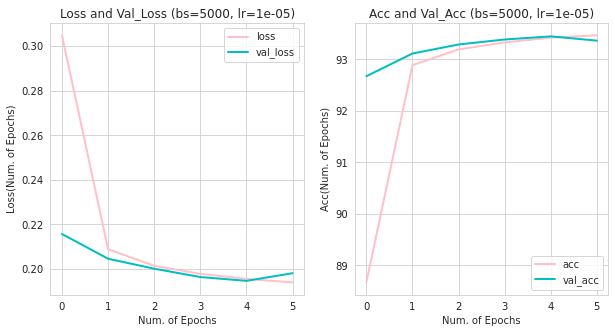

[{'epoch': 1,
  'loss': 0.3048959851540901,
  'time': 282.7272436702624,
  'acc': 88.6694065729777,
  'val_loss': 0.21567569797237715,
  'val_acc': 92.67266553243002},
 {'epoch': 2,
  'loss': 0.20882741902713423,
  'time': 283.41346894577146,
  'acc': 92.88725816232187,
  'val_loss': 0.20455882201592127,
  'val_acc': 93.11399981180827},
 {'epoch': 3,
  'loss': 0.2013970022124273,
  'time': 283.14670901186764,
  'acc': 93.19329550001356,
  'val_loss': 0.20008198668559393,
  'val_acc': 93.28899904886882},
 {'epoch': 4,
  'loss': 0.19776997751107922,
  'time': 283.72129020281136,
  'acc': 93.33070322672526,
  'val_loss': 0.19633936608831087,
  'val_acc': 93.38633346557617},
 {'epoch': 5,
  'loss': 0.19550528473876141,
  'time': 283.2902156487107,
  'acc': 93.42096282111274,
  'val_loss': 0.19461908141771952,
  'val_acc': 93.44699948628744},
 {'epoch': 6,
  'loss': 0.1939064656142835,
  'time': 283.6765110399574,
  'acc': 93.46655530576352,
  'val_loss': 0.19805904204646746,
  'val_acc': 9

In [40]:
model = Model(net, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
model.fit_generator(train_loader,
                    valid_loader,
                    epochs=num_epochs,
                    callbacks=[plot], 
                    verbose=0)